In [1]:
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from autoreject import AutoReject, Ransac
from autoreject.utils import interpolate_bads
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs, find_bad_channels_maxwell
from IPython.display import display, HTML
%matplotlib qt

In [2]:
montage = mne.channels.make_standard_montage("GSN-HydroCel-128")

Reading EGI MFF Header from C:\Learn\Project\bylw\eeg\1\lal-hc-459-task_20231126_022722.mff...
    Reading events ...
    Assembling measurement info ...
    Excluding events {} ...
Reading 0 ... 1566380  =      0.000 ...  3132.760 secs...


C:\Users\24323\AppData\Local\Temp\ipykernel_47364\1831873105.py:3: RuntimeWarning: DigMontage is only a subset of info. There is 1 channel position not present in the DigMontage. The channel missing from the montage is:

['VREF'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if this is not an EEG channel, or use the on_missing parameter if the channel position is allowed to be unknown in your analyses.
  raw_copy.set_montage(montage, on_missing='warn')


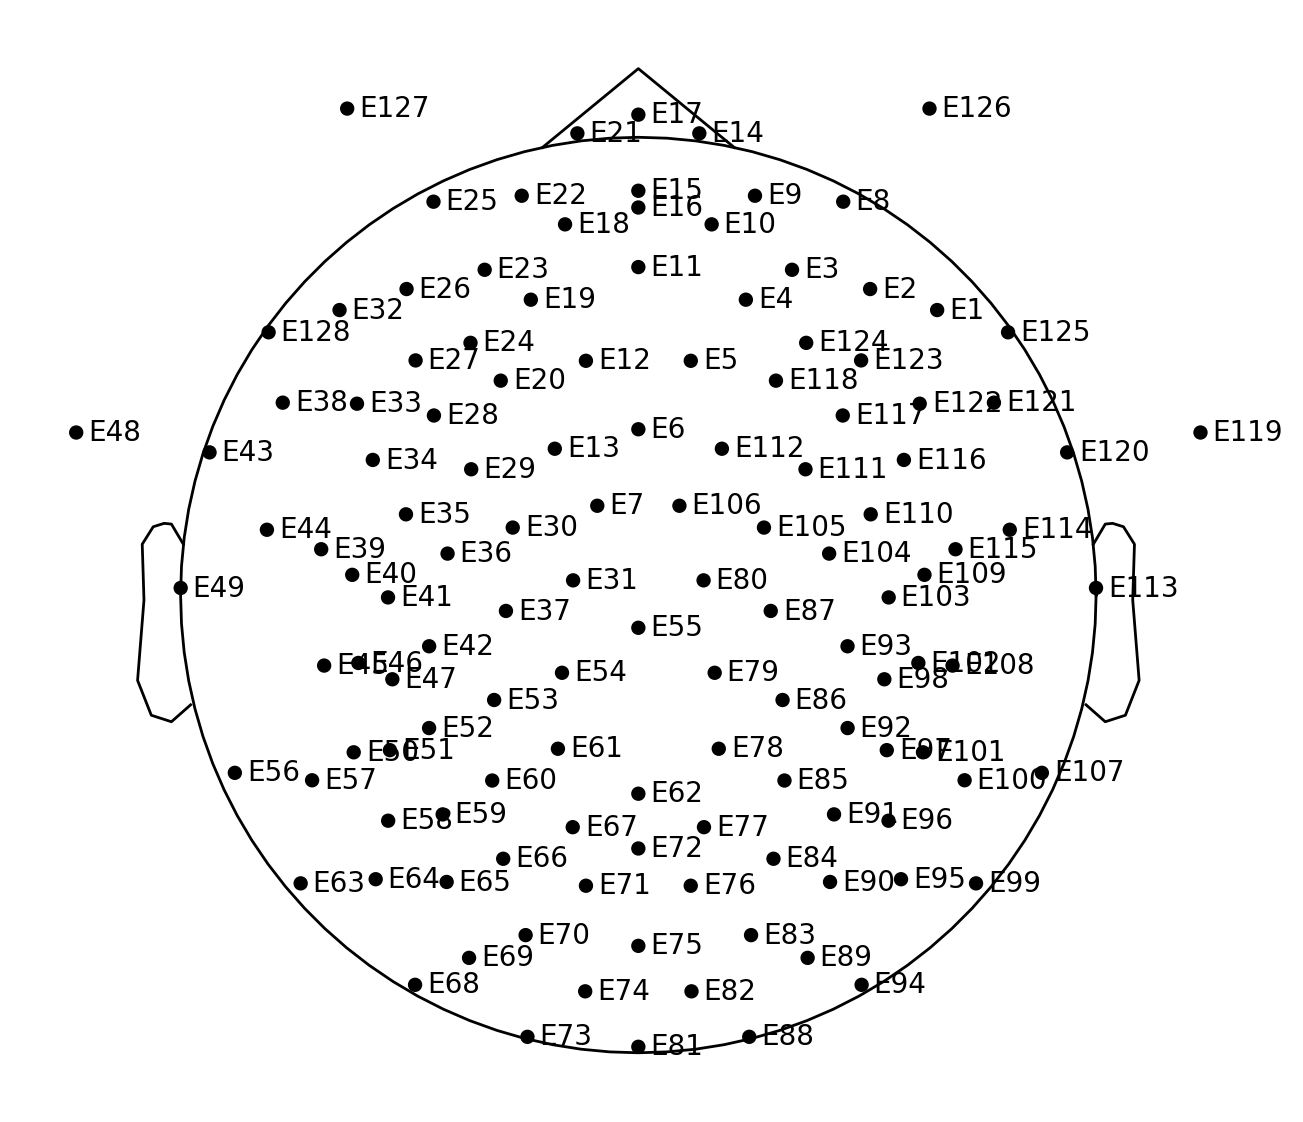

In [3]:
raw = mne.io.read_raw_egi("C:/Learn/Project/bylw/eeg/1/lal-hc-459-task_20231126_022722.mff", preload=True)
raw_copy = raw.copy()
raw_copy.set_montage(montage, on_missing='warn')

montage.plot(kind='topomap', show_names=True)
# raw_copy.plot()

In [7]:
events, event_dict = mne.events_from_annotations(raw_copy)

# 统计每个事件的数量
for event_name, event_code in event_dict.items():
    count = sum(events[:, 2] == event_code)
    print(f"事件 {event_name} (ID={event_code}) 出现次数: {count}")

Used Annotations descriptions: ['100 ', '101 ', '102 ', '103 ', '104 ', '105 ', '106 ', '108 ', '109 ', '110 ', '111 ', '112 ', '113 ', '114 ', '115 ', '2   ', '255 ', '3   ', '4   ', '5   ', '6   ', '800 ', '801 ', '900 ', '901 ']
事件 100  (ID=1) 出现次数: 63
事件 101  (ID=2) 出现次数: 57
事件 102  (ID=3) 出现次数: 38
事件 103  (ID=4) 出现次数: 41
事件 104  (ID=5) 出现次数: 18
事件 105  (ID=6) 出现次数: 21
事件 106  (ID=7) 出现次数: 1
事件 108  (ID=8) 出现次数: 45
事件 109  (ID=9) 出现次数: 51
事件 110  (ID=10) 出现次数: 60
事件 111  (ID=11) 出现次数: 48
事件 112  (ID=12) 出现次数: 13
事件 113  (ID=13) 出现次数: 17
事件 114  (ID=14) 出现次数: 2
事件 115  (ID=15) 出现次数: 3
事件 2    (ID=16) 出现次数: 480
事件 255  (ID=17) 出现次数: 2
事件 3    (ID=18) 出现次数: 480
事件 4    (ID=19) 出现次数: 480
事件 5    (ID=20) 出现次数: 480
事件 6    (ID=21) 出现次数: 480
事件 800  (ID=22) 出现次数: 204
事件 801  (ID=23) 出现次数: 36
事件 900  (ID=24) 出现次数: 199
事件 901  (ID=25) 出现次数: 41


In [5]:
for i in range(len(events)):
    print(events[i])

[4352    0   17]
[4601    0   19]
[4604    0   26]
[4850    0   20]
[5350    0   21]
[5600    0   22]
[5852    0   18]
[6784    0   17]
[7033    0   19]
[7034    0   25]
[7283    0   20]
[7783    0   21]
[8033    0   22]
[8291    0    1]
[9916    0   17]
[10166     0    19]
[10167     0    25]
[10416     0    20]
[10916     0    21]
[11166     0    22]
[11418     0     2]
[13008     0    17]
[13258     0    19]
[13259     0    25]
[13508     0    20]
[14008     0    21]
[14258     0    22]
[14510     0     3]
[15941     0    17]
[16191     0    19]
[16192     0    25]
[16441     0    20]
[16941     0    21]
[17191     0    22]
[17443     0     3]
[18675     0    17]
[18924     0    19]
[18926     0    26]
[19174     0    20]
[19674     0    21]
[19924     0    22]
[20191     0     5]
[21974     0    17]
[22224     0    19]
[22225     0    25]
[22474     0    20]
[22974     0    21]
[23224     0    22]
[23476     0     3]
[24599     0    17]
[24849     0    19]
[24851     0    25]
[2509

In [ ]:
target_event_ids = list(range(1, 16))
# 遍历修改
for i in range(len(events)):
    if events[i, 2] in target_event_ids:
        events[i, 2] = 1  # 修改事件 ID 为 1

# 显示修改后的结果，并打印所有事件 ID 为 1 的事件及其前后事件
print("修改后的 events（仅显示 ID 为 1 的事件及其前后事件）：")

# for i in range(len(events)):
#     print(events[i])

# 统计每个事件的数量
for event_name, event_code in event_dict.items():
    count = sum(events[:, 2] == event_code)
    print(f"事件 {event_name} (ID={event_code}) 出现次数: {count}")

In [ ]:
# 假设 `events` 是一个二维数组，形如 [时间点, 0, 事件ID]
# `sfreq` 是采样率（Hz），表示每秒多少个采样点
sfreq = raw.info['sfreq']  # 从 raw 数据中获取采样率

# 筛选事件 ID 为 1 和 16
selected_events = events[np.isin(events[:, 2], [1, 16])]

# # 显示选中的事件
# print("Selected events with ID 1 and 16:")
# for event in selected_events:
#     print(event)  # 每个 event 形如 [时间点, 0, 事件ID]

# 计算相邻事件之间的时间差（单位：采样点）
time_diffs_samples = np.diff(selected_events[:, 0])  

# 换算成秒（s）
time_diffs_seconds = time_diffs_samples / sfreq

# 显示每两个相邻 1 和 16 事件之间的时间差（单位：秒）
print("\nTime differences between consecutive events (ID 1 and 16) in seconds:")
for i, diff in enumerate(time_diffs_seconds):
    print(f"Difference {i + 1}: {diff:.3f} s")  # 保留 3 位小数

In [ ]:
for i in range(len(events)):
    print(events[i])

In [ ]:
sfreq = raw_copy.info['sfreq']

# 提取 event_id = 17 和 event_id = 1 的时间点（单位：采样点）
times_17 = events[events[:, 2] == 17][:, 0]  # 取出所有 event_id=17 的时间点
times_1 = events[events[:, 2] == 1][:, 0]    # 取出所有 event_id=1 的时间点

# 确保事件按时间顺序排列
times_17.sort()
times_1.sort()

# 计算最近的 event_id=1 到 event_id=17 之间的时间差（单位：采样点）
time_differences = []
for t1 in times_1:
    t17_after_t1 = times_17[times_17 > t1]  # 找到 t1 之后的第一个 event_id=17
    if len(t17_after_t1) > 0:
        time_differences.append(t17_after_t1[0] - t1)  # 计算时间差

# 转换为秒
time_differences_sec = np.array(time_differences) / sfreq

time_differences_sec

In [ ]:
# 去除channel
raw_copy.drop_channels(['E1', 'E2','E9','E14', 'E15', 'E17', 'E21','E22', 'E26', 'E32', 'E38', 'E39', 'E43', 'E44', 'E45', 'E48', 'E49', 'E108', 'E113', 'E114', 'E115', 'E119', 'E120', 'E121', 'E125', 'E128'])
# raw_copy.ch_names
eogs = {item:'eog' for item in [ 'E8', 'E25', 'E126', 'E127']}
raw_copy.set_channel_types({'VREF': 'misc'})
raw_copy.set_channel_types(eogs)

In [ ]:
raw_copy.set_montage(montage)
# fig = raw_copy.plot_sensors(show_names=True)

In [ ]:
# 重参考
raw_copy.set_eeg_reference('average', ch_type='eeg')

In [ ]:
raw_copy.plot_psd()

In [ ]:
# 滤波
picks = mne.pick_types(raw_copy.info, eeg=True, eog=True)
raw_copy.filter(l_freq=0.1, h_freq=30, fir_design='firwin', phase='zero-double', picks=picks)


In [ ]:
# fig = raw_copy.compute_psd().plot(
#     average=True, amplitude=False, picks="data", exclude="bads"
# )

In [ ]:

# raw_copy.resample(200)

In [ ]:
tmin_1, tmax_1 = -0.7, 1     # Mark=1 的时间范围

# 提取 Mark=1 的 epochs
epochs_combined = mne.Epochs(raw_copy, events, event_id=19, 
                       tmin=tmin_1, tmax=tmax_1, 
                       baseline=None, preload=True)

# ica
ica = mne.preprocessing.ICA(n_components=15, random_state=97, method="infomax", max_iter=3000)
ica.fit(epochs_combined)

eog_inds, scores = ica.find_bads_eog(epochs_combined,measure='correlation',threshold=0.4)
ica.exclude = eog_inds
print(eog_inds)

epochs_combined = ica.apply(epochs_combined.copy())

In [ ]:
# 截取

# 时间窗口
tmin_1, tmax_1 = -0.2, 0     # Mark=1 的时间范围
tmin_2, tmax_2 = 0, 1.5   # Mark=2 的时间范围

# 提取 Mark=1 的 epochs
epochs_1 = mne.Epochs(raw_copy, events, event_id=1, 
                       tmin=tmin_1, tmax=tmax_1, 
                       baseline=None, preload=True)

# 提取 Mark=2 的 epochs
epochs_2 = mne.Epochs(raw_copy, events, event_id=17, 
                       tmin=tmin_2, tmax=tmax_2, 
                       baseline=None, preload=True)
epochs_2.drop(indices=[0, 1])  # 删除第 0 和第 1 个 epoch

# # ica
# ica = mne.preprocessing.ICA(n_components=0.99, random_state=97, method="infomax", max_iter=3000)
# ica.fit(epochs_2)
# ica.plot_components()

# eog_inds, scores = ica.find_bads_eog(epochs_2,measure='correlation',threshold=0.4)
# ica.exclude = eog_inds
# print(eog_inds)

# epochs_2 = ica.apply(epochs_2.copy())

# 确保两个 epochs 数量相等
assert len(epochs_1) == len(epochs_2), "Mark=1 和 Mark=2 事件数量不匹配！"

trial_1 = epochs_1.get_data()  # 取 Mark=1 片段
trial_2 = epochs_2.get_data()  # 取 Mark=2 片段
print("trial2_shape: ", trial_2.shape)
    
# 在时间轴 (axis=2) 方向拼接
concatenated_data = np.concatenate([trial_1, trial_2], axis=2)

# 转换为 NumPy 数组
concatenated_data = np.array(concatenated_data)

# 创建新的 EpochsArray
info = raw_copy.info  # 继承原始数据的通道信息
epochs_combined = mne.EpochsArray(concatenated_data, info)
# epochs_combined.filter(None,30,fir_design='firwin', phase='zero-double', picks=picks)
# 查看新 epochs 结构
print(epochs_combined)



In [ ]:
# ica
ica = mne.preprocessing.ICA(n_components=0.9, random_state=97, method="infomax", max_iter=3000)
ica.fit(epochs_combined)

eog_inds, scores = ica.find_bads_eog(epochs_combined,measure='correlation',threshold=0.4)
ica.exclude = eog_inds
print(eog_inds)

epochs_combined = ica.apply(epochs_combined.copy())

In [ ]:
ica.plot_sources(epochs_combined)
ica.plot_components()

In [ ]:
# pick_ica = [0,1,2,3]
# ica.plot_properties(epochs_combined)


In [ ]:
# pick_ica = [11]
# ica.plot_properties(epochs_combined, picks=pick_ica)

In [ ]:
epochs_combined

In [ ]:
epochs_combined.apply_baseline((-0.7,-0.5))

evoke = epochs_combined.average()
evoke.pick(["E6", "E62"])
evoke.plot_joint() 

In [ ]:
# 自动删除坏导
# 初始化AutoReject，可自定义参数（如n_interpolate控制最大插值通道数）
picks = mne.pick_types(epochs_combined.info,eeg=True, eog=False)
ar = Ransac(verbose=True, picks=picks, n_jobs=1, min_channels=0.1)
epochs_clean = ar.fit_transform(epochs_combined)
# epochs_clean.apply_baseline((-0.2,0))

In [ ]:
epochs_clean.average().plot_joint()

In [ ]:
epochs.events

In [ ]:
raw.info['nchan']

In [ ]:
raw.info